# Transfer Learning

## Objective

In this tutorial, we will look at classifying images from a dataset by using transfer learning from a pre-trained network. In our case, we will use resnet-18. You will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

2. Fine-Tuning: We use the pre-trained model as a starting point and then train not only a new classifier on top of the pretrained model, but also continue to backpropagate and then train the total network. 

## Dataset

We will use the Hymenoptera dataset of ants and bees from this [link](https://www.kaggle.com/datasets/ajayrana/hymenoptera-data) for our transfer learning tutorial. Download the zip file and extract the files. Each category ('ants' / 'bees') consists of 120 images for training and 75 images for validation. The dataset is a small subset of the Imagenet dataset.

## Task

In this notebook, you will be

- Loading the new dataset and pre-processing it for training
- Loading a pretrained base model
- Fine-tuning the base model on the new dataset and examining its performance
- Finally use the base model as a feature extractor and again examining its performance

Just like in the previous notebooks, most of the exercises include completing missing code segments. Please got through the notebook sequentially and find the relevant instructions in the code cells / markdown above the code cells. Also, as always, feel free to add comments beside your code for ease of understanding.

In [4]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import os
import time
import copy
import numpy as np
import torch
from torch import nn
import matplotlib
import torchvision
from datetime import datetime
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import models

In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Print out the version of the packages
print("pytorch=={}".format(torch.__version__))
print("torchvision=={}".format(torchvision.__version__))
print("numpy=={}".format(np.__version__))
print("matplotlib=={}".format(matplotlib.__version__))

pytorch==1.6.0
torchvision==0.7.0
numpy==1.20.3
matplotlib==3.4.3


### Pre-processing the dataset

[**datasets.ImageFolder**](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) basically provides a data structure where these images are arranged such that:

`data_dir/train/ants/x.png,`

`data_dir/train/ants/y.png,`

`data_dir/train/ants/z.png,`

`data_dir/train/ants/w.png ...`

Note that, the above organization is an example structure, where `data_dir` represents the exact location where you're extracted dataset is present. Inside the folder you will have two folders `train` and `val` containing training and validation set images respectively. Additionally, specific transforms can be used on the input images using `torchvision.transforms`

Task: Create a dictionary `image_datasets` that consists of the training and validation datasets under two keys `train` and `val` respectively. Remember training and validation datasets are stored under `data_dir/train/...` and `data_dir/val/...` respectively. Load the datasets using `datasets.ImageFolder` and specify appropriate transforms from the dictionary `data_transforms` which is already given

In [143]:
# Set dataset related parameters here:
BATCH_SIZE = 64 # Batch size for the data loader
train_to_val_split = 0.8 # Percentage of the validation set to be used as the testing set

In [144]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './drive/MyDrive/data/hymenoptera_data/' #'./hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [146]:
def imshow(inp, title=None):
    """
    Defining a function to display images from the hymenoptera dataset
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
    return None

## Make sure dataset is loaded correctly

### Create an additional test dataset by partitioning the validation set

We create a test dataset by using the validation set since the original dataset was only partitioned into training and validation datasets. For validation, we use a part of the training dataset

In [147]:
def create_val_and_test_loaders(image_datasets, train_to_val_split):
    
    # Create the dataloaders 

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Split the training dataset as per 'train_to_val_split' into training and validation sets
    num_train_plus_val_samples = dataset_sizes['train']
    indices_train_plus_val_permuted = torch.randperm(num_train_plus_val_samples)
    num_train_samples = int(train_to_val_split * num_train_plus_val_samples)
    num_val_samples = num_train_plus_val_samples - num_train_samples
    idx_train = indices_train_plus_val_permuted[:num_train_samples]
    idx_val = indices_train_plus_val_permuted[num_train_samples:]

    # Recreate the validation dataset loader and test dataset loader

    dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE,
                                                     sampler=SubsetRandomSampler(idx_train),
                                                     num_workers=2)
    
    dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE,
                                                     sampler=SubsetRandomSampler(idx_val),
                                                     num_workers=2)

    dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     num_workers=2)
    
    return dataloaders, dataset_sizes, device, class_names

In [148]:
dataloaders, dataset_sizes, device, class_names = create_val_and_test_loaders(image_datasets, train_to_val_split)

### Examining some of the images of the training set

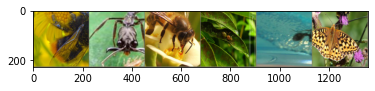

In [149]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:6], nrow=6)
imshow(out)

### Defining the function to train the model

Task: Complete the function `evaluate_model` to test the trained model on the dataloader specified by `mode` (`mode`can be 'test' / 'val'). Note that here no gradients should be computed for the model

In [150]:
def evaluate_model(trained_model, dataloaders, mode='test', device='cpu'):
    
    num_total = 0
    num_correct = 0
    start_time = datetime.now()
    
    trained_model.eval()
    # To avoid the computation of the gradients during the forward pass,
    # We use the torch.no_grad() environment
    with torch.no_grad():
        
        for _, test_data in enumerate(dataloaders[mode]):
            
            test_images, test_labels = test_data
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)
            test_outputs = trained_model(test_images)
            _, test_predicted = torch.max(test_outputs.data, 1)
            num_total += test_labels.size(0)
            num_correct += (test_predicted == test_labels).sum().item()
            
    time_elapsed = (datetime.now() - start_time).total_seconds()
    eval_acc = 100 * num_correct / num_total # Calculating the accuracy on the evaluation set in percentage
    
    print("Accuracy of the network on the {} images: {} %".format(
        mode, eval_acc))
    print("Evaluation runtime: {:.3f} secs".format(time_elapsed))
    
    return eval_acc

## Training the model

Task: Complete parts of the code for training the base model 

In [153]:
def train_model(model, dataloaders, criterion, optimizer, lr_scheduler, num_epochs=10, device='cpu'):
    
    start_time = time.time()
    best_model_wts = None
    best_validation_acc = 0.0
    tr_running_loss = 0.0
    tr_loss_epoch_sum = 0.0
    train_total = 0.0 
    train_correct = 0.0
    best_validation_epoch = None
    
    for epoch in range(num_epochs):
        
        model.train()
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        # Iterate over data.
        for i, tr_data in enumerate(dataloaders['train'],0):
            
            tr_inputs, tr_labels = tr_data
            tr_inputs = tr_inputs.to(device)
            tr_labels = tr_labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            tr_outputs = model(tr_inputs)
            _, tr_predicted = torch.max(tr_outputs, 1)
            tr_loss = criterion(tr_outputs, tr_labels)
            tr_loss.backward()
            optimizer.step()

            # statistics
            tr_loss_epoch_sum += tr_loss.item()
            tr_running_loss += tr_loss.item() #* inputs.size(0)
            
            if i % 5 == 4:
                # print progress statistics
                print("Epoch: {:d}/{:d}, batch_no.: {:5d}, loss: {:.3f}".format(
                    epoch + 1, num_epochs, i+1, tr_running_loss / 5
                ))
                tr_running_loss = 0.0
               
            #if phase == 'train':
            train_total += tr_labels.size(0)
            train_correct += (tr_predicted == tr_labels).sum().item()
        
        tr_loss_epoch = tr_loss / len(dataloaders['train'])
        tr_acc_epoch = 100 * train_correct / train_total
        
        lr_scheduler.step()
        
        val_acc_epoch = evaluate_model(model, dataloaders, mode='val', device=device)
        
        print("Tr. loss: {:.3f}, Training set accuracy: {:.3f}, Validation set accuracy: {:.3f}".format(
                    tr_loss_epoch, tr_acc_epoch, val_acc_epoch))
        
        # deep copy the model
        if val_acc_epoch > best_validation_acc:
            best_validation_acc = val_acc_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            best_validation_epoch = epoch + 1

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_validation_acc))
    print("Saving model at Epoch: {} ...".format(best_validation_epoch))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing some of the predictions of the model

The `visualize_model` function takes some images from the validation set and evaluates the trained model on that set

In [154]:
def visualize_model(trained_model, num_images=6,  device='cpu'):
    
    was_training = trained_model.training
    trained_model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = trained_model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    trained_model.train(mode=was_training)
                    return
                    
        trained_model.train(mode=was_training)

## Fine-tuning a trained network

In this first task, we will fine-tune the weights of pre-trained base-model
using the new dataset. This will involve changing the last layer to account for the number of classes of the new dataset. By default the initialization with an nn.Module say nn.Linear sets the layer to have `requires_grad = True`

In [155]:
def change_last_layer(model_ft, num_classes, device):
    """ This function pushes the model to the device 'cpu/gpu' and resets the last layer to include the appropriate number of 
    classes
    """
    # The last layer is usually a fully connected layer. Get the number of features of the last
    # fully connected layer
    num_ftrs = model_ft.fc.in_features 
    # Reset the last layer by using a linear layer that uses the same number of 
    # input features, but different number of output classes
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    # Push the 
    model_ft = model_ft.to(device)

    return model_ft

In [157]:
model_ft = models.resnet18(pretrained=True) # Load a pre-trained resnet18 model from torchvision.models
model_ft = change_last_layer(model_ft, num_classes=len(class_names), device=device)
criterion = nn.CrossEntropyLoss() # Define a loss criterion
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # Set an optimizer
exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.99) # Use an exponential learning rate decaying function

Training starts for the fine-tuned model

In [159]:
model_fine_tuned = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15, device=device)

Epoch 1/15
Accuracy of the network on the val images: 57.142857142857146 %
Evaluation runtime: 0.857 secs
Tr. loss: 0.151, Training set accuracy: 48.718, Validation set accuracy: 57.143
Epoch 2/15
Accuracy of the network on the val images: 59.183673469387756 %
Evaluation runtime: 0.859 secs
Tr. loss: 0.109, Training set accuracy: 54.103, Validation set accuracy: 59.184
Epoch 3/15
Accuracy of the network on the val images: 93.87755102040816 %
Evaluation runtime: 0.861 secs
Tr. loss: 0.160, Training set accuracy: 58.120, Validation set accuracy: 93.878
Epoch 4/15
Accuracy of the network on the val images: 89.79591836734694 %
Evaluation runtime: 0.846 secs
Tr. loss: 0.053, Training set accuracy: 65.128, Validation set accuracy: 89.796
Epoch 5/15
Accuracy of the network on the val images: 93.87755102040816 %
Evaluation runtime: 0.899 secs
Tr. loss: 0.084, Training set accuracy: 69.538, Validation set accuracy: 93.878
Epoch 6/15
Accuracy of the network on the val images: 89.79591836734694 %

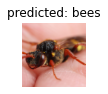

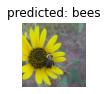

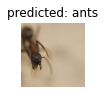

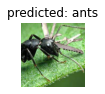

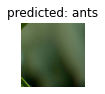

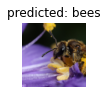

In [160]:
# Check the visualization on some images from the validation set
visualize_model(model_fine_tuned, device=device)
plt.ioff()
plt.show()

In [161]:
test_acc_epoch = evaluate_model(model_fine_tuned, dataloaders, mode='test', device=device)

Accuracy of the network on the test images: 90.19607843137256 %
Evaluation runtime: 1.582 secs


## Pre_trained_model as a fixed feature extractor

In this part, we use the pretrained base model as a fixed feature extractor. By fixed, we mean that all layers of the base model except the last layer are frozen and no gradients will be computed on them. Gradients are only optimized for the last layer 

In [162]:
def freeze_all_layers(model, device='cpu'):
    """
    This function helps freeze all layers of the network and 
    pushes the model to the correct device
    """
    for param in model.parameters():
        param.requires_grad = False
    model = model.to(device)
    return model

In [164]:
model_conv = torchvision.models.resnet18(pretrained=True) # We again load a base model that is pre-trained
model_conv = freeze_all_layers(model_conv, device=device) # We freeze all layers
model_conv = change_last_layer(model_conv, num_classes=len(class_names), device=device) # We unfreeze only the last layer
criterion = nn.CrossEntropyLoss() 
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9) # Observe that only parameters of final layer are being optimized as opposed to before.
exp_lr_scheduler_conv = torch.optim.lr_scheduler.ExponentialLR(optimizer_conv, gamma=0.99) # Use an exponential learning rate decaying function

In [166]:
model_conv = train_model(model_conv, dataloaders, criterion, optimizer_conv,
                         exp_lr_scheduler_conv, num_epochs=15, device=device)

Epoch 1/15
Accuracy of the network on the val images: 63.265306122448976 %
Evaluation runtime: 0.923 secs
Tr. loss: 0.174, Training set accuracy: 53.846, Validation set accuracy: 63.265
Epoch 2/15
Accuracy of the network on the val images: 61.224489795918366 %
Evaluation runtime: 0.929 secs
Tr. loss: 0.297, Training set accuracy: 55.385, Validation set accuracy: 61.224
Epoch 3/15
Accuracy of the network on the val images: 73.46938775510205 %
Evaluation runtime: 0.887 secs
Tr. loss: 0.132, Training set accuracy: 60.513, Validation set accuracy: 73.469
Epoch 4/15
Accuracy of the network on the val images: 89.79591836734694 %
Evaluation runtime: 0.871 secs
Tr. loss: 0.176, Training set accuracy: 62.692, Validation set accuracy: 89.796
Epoch 5/15
Accuracy of the network on the val images: 75.51020408163265 %
Evaluation runtime: 0.881 secs
Tr. loss: 0.085, Training set accuracy: 67.077, Validation set accuracy: 75.510
Epoch 6/15
Accuracy of the network on the val images: 83.6734693877551 %


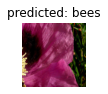

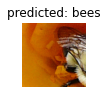

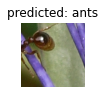

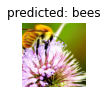

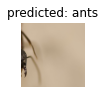

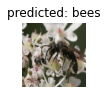

In [167]:
visualize_model(model_conv, device=device)
plt.ioff()
plt.show()

In [168]:
test_acc_epoch_conv = evaluate_model(model_conv, dataloaders, mode='test', device=device)

Accuracy of the network on the test images: 92.81045751633987 %
Evaluation runtime: 1.692 secs
